In [1]:
import numpy as np

class AdalineGD:
    """ADAptive LInear NEuron classifier

    Parameters
    ------------
    eta : float 
        Learning rate (etween 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset
    random_state : int
        Random number generator seed for random weight init
        
    Attributes
    ------------
    w_ : 1-d array
        Weights after fitting
    b_ : Scalar
        Bias unit after fitting
    losses_ : list
        Number of mis
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        ------------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors
        y : array-like, shape = [n_examples]
            Target values

        Returns
        ------------
        self: object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])

        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)

        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [2]:
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, header=None, encoding='utf-8')
# Select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1) # Setosa is 0, Versicolor 1
# Extract sepal and petal lengths
X = df.iloc[0:100, [0, 2]].values

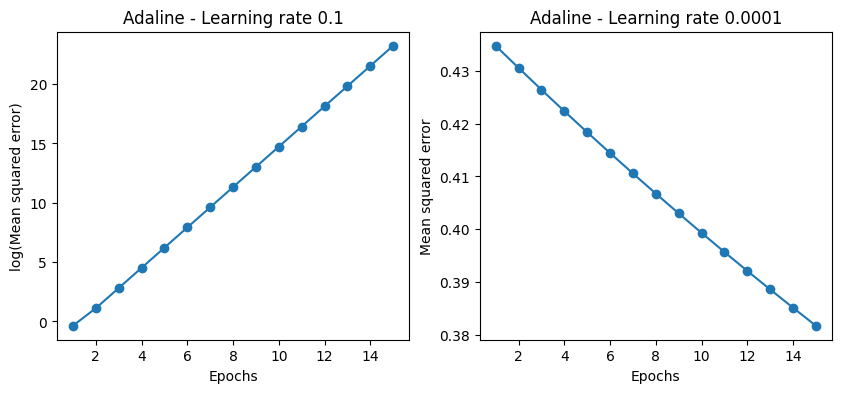

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_)+1),
           np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_)+1),
           ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

### User standardization


In [4]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [5]:
ada_gd = AdalineGD(n_iter=20, eta=0.5)
ada_gd.fit(X_std, y)

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])  # In this case we will use only the red and blue colors since we have 2 unique y

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # Get min and max feature values for x1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Get min and max feature values for x2

    # meshgrid makes a rectangular grid out of given x, y coordinates
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

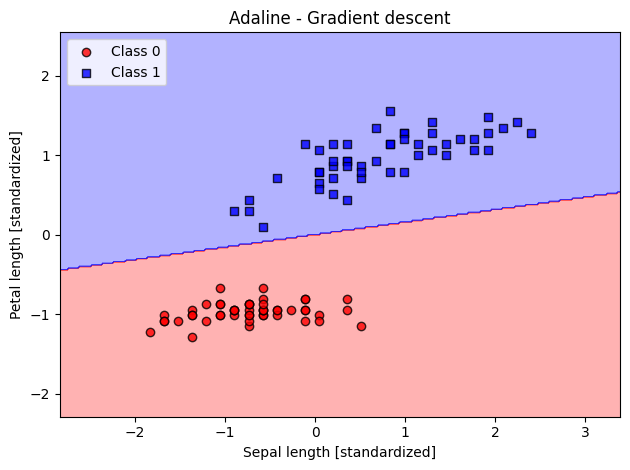

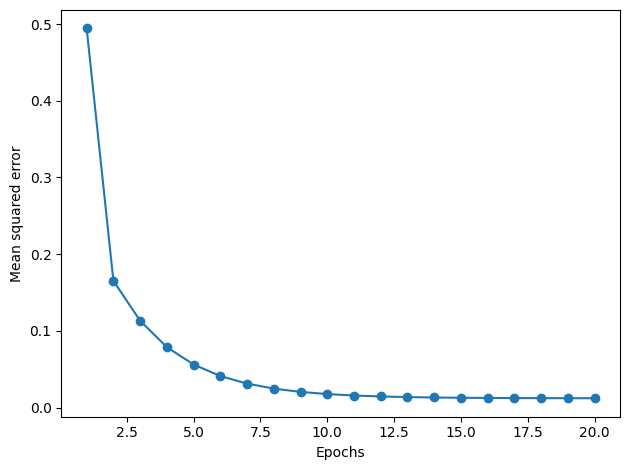

In [7]:
plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

### Stochastic Gradient Descent

In [8]:
import numpy as np

class AdalineSGD:
    """ADAptive LInear NEuron classifier

    Parameters
    ------------
    eta : float 
        Learning rate (etween 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset
    shuffle : bool (default: True)
        Shuffles the training data every epoch to prevent cycles.
    random_state : int
        Random number generator seed for random weight init
        
    Attributes
    ------------
    w_ : 1-d array
        Weights after fitting
    b_ : Scalar
        Bias unit after fitting
    losses_ : list
        MSE error loss function value averaged over all training exmaples in each epoch
    """
    def __init__(self, eta=0.01, n_iter=50,
                 shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        ------------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors
        y : array-like, shape = [n_examples]
            Target values

        Returns
        ------------
        self: object
        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []

        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        
        return self
    
    def partial_fit(self, X, y):
        """Fit trainig data without reninitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])

        if y.ravel().shape[0] > 1:  # If more than 1 training example
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:  # If only a single training example
            self._update_weights(X, y)
        
        return self

    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.0)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """ Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * error
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

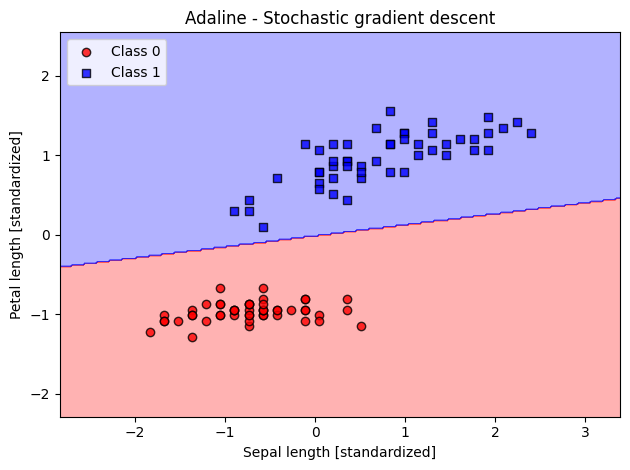

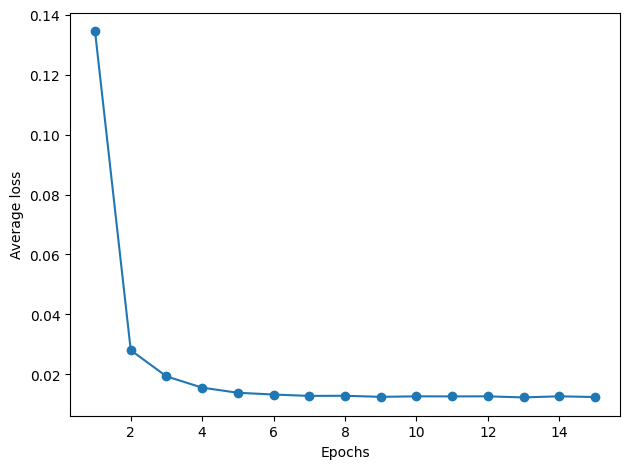

In [10]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.tight_layout()
plt.show()